 # MTH8408 : Méthodes d'optimisation et contrôle optimal
 ## Laboratoire 5: Optimisation avec contraintes et calcul variationnel
Tangi Migot et Paul Raynaud

In [1]:
using Pkg
Pkg.add("Krylov")
Pkg.add("LinearAlgebra")
Pkg.add("Logging")
Pkg.add("NLPModels")
Pkg.add("NLPModelsIpopt")
Pkg.add("Printf")
Pkg.add("SolverCore")
Pkg.add("Test")
Pkg.add("PDENLPModels")
Pkg.add("Gridap")
Pkg.add("ADNLPModels")
Pkg.add("NLPModelsIpopt")
Pkg.add("Plots")
Pkg.add("OptimizationProblems")
Pkg.add("JSOSolvers")
Pkg.add("SolverBenchmark")

┌ Warning: could not download https://pkg.julialang.org/registries
│   exception = Downloads.RequestError("https://pkg.julialang.org/registries", 6, "Could not resolve host: pkg.julialang.org", Downloads.Response(nothing, "https://pkg.julialang.org/registries", 0, "", Pair{String, String}[]))
└ @ Pkg.Registry C:\Users\Hortie\.julia\juliaup\julia-1.10.0+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Registry\Registry.jl:69
   Resolving package versions...
  No Changes to `C:\Users\Hortie\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Hortie\.julia\environments\v1.10\Manifest.toml`
Precompiling project...
  ? PDENLPModels
   Resolving package versions...
  No Changes to `C:\Users\Hortie\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Hortie\.julia\environments\v1.10\Manifest.toml`
Precompiling project...
  ? PDENLPModels
   Resolving package versions...
  No Changes to `C:\Users\Hortie\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Us

In [2]:
using Krylov, LinearAlgebra, Logging, NLPModels, NLPModelsIpopt, Printf, SolverCore, Test

In [3]:
using PDENLPModels, Gridap, ADNLPModels

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


## Quelques commentaires en Julia

### Les kwargs: choix optionnels

Dans le projet du dernier labo, une des questions demandait d'ajouter une option pour utiliser la fonction `lsmr` ou `lsqr`. C'est le cas typique d'arguments optionnels:
- On veut proposer un choix par défaut à l'utilisateur, par exemple `lsqr`;
- On veut laisser la possibilité à l'utilisateur de changer;
- On voudrait aussi pouvoir ajouter d'autres par la suite (sans avoir à tout modifier).

In [4]:
function dsol(A, b, ϵ; solver :: Function = lsqr)
    (d, stats) = solver(A, b, atol = ϵ)
    return d
end

dsol (generic function with 1 method)

A noter que l'on donne des valeurs par défaut aux arguments qui apparaissent après le `;`.

## Exercice 1: Pénalité quadratique pour les ADNLPModels

Dans cet exercice, on va étudier une version simple d'une méthode de pénalité quadratique pour les problèmes d'optimisation avec contraintes d'égalité.
```math
min f(x) s.à c(x) = 0.
```
Dans les labos précédents, on a déjà utilisé un NLPModel particulier, le ADNLPModel:

In [5]:
using ADNLPModels, LinearAlgebra, Test
fH(x) = (x[2]+x[1].^2-11)^2 + (x[1]+x[2].^2-7)^2
x0H = [10., 20.]
cH(x) = [x[1]-1]
himmelblau = ADNLPModel(fH, x0H, cH, [0.], [0.])

ADNLPModel - Model with automatic differentiation backend ADModelBackend{
  ForwardDiffADGradient,
  ForwardDiffADHvprod,
  ForwardDiffADJprod,
  ForwardDiffADJtprod,
  ForwardDiffADJacobian,
  ForwardDiffADHessian,
  ForwardDiffADGHjvprod,
}
  Problem name: Generic
   All variables: ████████████████████ 2      All constraints: ████████████████████ 1     
            free: ████████████████████ 2                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ████████████████████ 1     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (  0.00% sparsity)   3               linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
     

Attention: dans toute la suite de l'exercice on suppose que les bornes sur les contraintes `nlp.meta.lcon` et `nlp.meta.ucon` sont 0 pour simplifier.

### Question 1: Transformer un ADNLPModel en un problème pénalisé
Coder la fonction `quad_penalty_adnlp` qui prend en entrée un ADNLPModel, et un paramètre ρ et qui retourne un nouveau ADNLPModel qui correspond au problème sans contrainte:
$$
\min_x f(x) + \frac{\rho}{2}\|c(x)\|^2.
$$
Remarque: on peut accèder aux fonctions f et c par `NLPModels.obj()` et `NLPModels.cons()`.

In [6]:
function quad_penalty_adnlp(nlp :: ADNLPModel, ρ :: Real)
    f = x -> obj(nlp, x) + (ρ/2)*(norm(cons(nlp, x)))^2
    x0 = nlp.meta.x0
    nlp_quad = ADNLPModel(f, x0)
   return nlp_quad
end

quad_penalty_adnlp (generic function with 1 method)

In [7]:
#Faire des tests pour vérifier que ça fonctionne.
fH(x) = (x[2]+x[1].^2-11)^2 + (x[1]+x[2].^2-7)^2
x0H = [10., 20.]
cH(x) = [x[1]-1]
himmelblau = ADNLPModel(fH, x0H, cH, [0.], [0.])

himmelblau_quad = quad_penalty_adnlp(himmelblau, 1)
@test himmelblau_quad.meta.ncon == 0
@test obj(himmelblau_quad, zeros(2)) == 170.5

Test Passed

In [8]:
#Ajouter au moins un autre test similaire avec des contraintes.
n = 10
nlp_test1 = ADNLPModel(x->dot(x, x), zeros(n), x->[sum(x) - 1], zeros(1), zeros(1))
nlp_test1_quad = quad_penalty_adnlp(nlp_test1, 1)
@test nlp_test1_quad.meta.ncon == 0
@test obj(nlp_test1_quad, zeros(n)) == 0.5

nlp_test2 = ADNLPModel(x->(x[1] - 1.0)^2 + 100 * (x[2] - x[1]^2)^2, [-1.2; 1.0], x->[sum(x)-1], [0.0], [0.0])
nlp_test2_quad = quad_penalty_adnlp(nlp_test2, 1)
@test nlp_test2_quad.meta.ncon == 0
@test obj(nlp_test2_quad, zeros(2)) == 1.5

Test Passed

In [9]:
# Ajouter un test au cas ou `nlp.meta.lcon` ou `nlp.meta.ucon` ont des composantes differentes de 0.
fH2(x) = (x[2]+x[1].^2-11)^2 + (x[1]+x[2].^2-7)^2
x0H2 = [10., 20.]
cH2(x) = [x[1]-1]
himmelblau2 = ADNLPModel(fH2, x0H2, cH2, [0.1], [0.1])

himmelblau2_quad = quad_penalty_adnlp(himmelblau2, 1)
@test himmelblau2_quad.meta.ncon == 0
@test himmelblau2_quad.meta.lcon != 0
@test himmelblau2_quad.meta.ucon != 0
@test obj(himmelblau2_quad, zeros(2)) == 170.5

Test Passed

### Question 2: KKT
Coder une fonction `KKT_eq_constraint(nlp :: AbstractNLPModel, x, λ)` qui vérifie si le point `x` avec multiplicateur de Lagrange `λ` satisfait les conditions KKT d'un problème avec contraintes d'égalités.

In [ ]:
function KKT_eq_constraint(nlp :: AbstractNLPModel, x, λ)
   if isapprox(grad(nlp, x), dot(jac(nlp, x),λ) ; atol=1e-6) || isapprox(cons(nlp, x), 0 ; atol=1e-6)
     return 1
   else
     return 0
   end
 end

In [ ]:
#test

### Question 3: méthode de pénalité quadratique

In [10]:
using NLPModelsIpopt

In [11]:
function quad_penalty(nlp      :: AbstractNLPModel,
    x        :: AbstractVector; 
    ϵ        :: AbstractFloat = 1e-3,
    η        :: AbstractFloat = 1e6, 
    σ        :: AbstractFloat = 2.0,
    max_eval :: Int = 1_000, 
    max_time :: AbstractFloat = 60.,
    max_iter :: Int = typemax(Int64)
    )
##### Initialiser cx et gx au point x;
cx = cons(nlp, x)
gx = grad(nlp, x)
######################################################
normcx = normcx_old = norm(cx)

ρ = 1.

iter = 0    

el_time = 0.0
tired   = neval_cons(nlp) > max_eval || el_time > max_time
status  = :unknown

start_time = time()
too_small  = false
normdual   = norm(gx) #exceptionnellement on ne va pas vérifier toute l'optimalité au début.
optimal    = max(normcx, normdual) ≤ ϵ

nlp_quad   = quad_penalty_adnlp(nlp, ρ)

@info log_header([:iter, :nf, :primal, :status, :nd, :Δ],
[Int, Int, Float64, String, Float64, Float64],
hdr_override=Dict(:nf => "#F", :primal => "‖F(x)‖", :nd => "‖d‖"))

while !(optimal || tired || too_small)

#Appeler Ipopt pour résoudre le problème pénalisé en partant du point x0 = x.
#utiliser l'option print_level = 0 pour enlever les affichages d'ipopt.
stats = ipopt(nlp_quad, print_level = 0)
################################################

if stats.status == :first_order
###### Mettre à jour cx avec la solution renvoyé par Ipopt
x = stats.solution
cx = cons(nlp, x)
##########################################################
normcx_old = normcx
normcx = norm(cx)
end

if normcx_old > 0.95 * normcx
ρ *= σ
end

@info log_row(Any[iter, neval_cons(nlp), normcx, stats.status])

nlp_quad   = quad_penalty_adnlp(nlp, ρ)

el_time      = time() - start_time
iter   += 1
many_evals   = neval_cons(nlp) > max_eval
iter_limit   = iter > max_iter
tired        = many_evals || el_time > max_time || iter_limit || ρ ≥ η
##### Utiliser la réalisabilité dual renvoyé par Ipopt pour `normdual`
normdual     = stats.dual_feas
###################################################################
optimal      = max(normcx, normdual) ≤ ϵ
end

status = if optimal 
:first_order
elseif tired
if neval_cons(nlp) > max_eval
:max_eval
elseif el_time > max_time
:max_time
elseif iter > max_iter
:max_iter
else
:unknown_tired
end
elseif too_small
:stalled
else
:unknown
end

return GenericExecutionStats(nlp, status = status, solution = x,
               objective = obj(nlp, x),
               primal_feas = normcx,
               dual_feas = normdual,
               iter = iter, 
               elapsed_time = el_time,
               solver_specific = Dict(:penalty => ρ))
end

quad_penalty (generic function with 1 method)

In [12]:
#Faire des tests pour vérifier que ça fonctionne.
stats = quad_penalty(himmelblau, x0H)
@test stats.status == :first_order
@test stats.solution ≈ [1.0008083416169895, 2.709969135758311] atol=1e-2
@test norm(cons(himmelblau, stats.solution)) ≈ 0. atol=1e-3



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\Hortie\OneDrive - polymtl.ca\Documents\GitHub\MTH8408-Hiv24\lab5\Lab5-notebook.ipynb:31
┌ Info:      0      36   2.0e+00      first_order
└ @ Main c:\Users\Hortie\OneDrive - polymtl.ca\Documents\GitHub\MTH8408-Hiv24\lab5\Lab5-notebook.ipynb:55
┌ Info:      1      70   1.9e+00      first_order
└ @ Main c:\Users\Hortie\OneDrive - polymtl.ca\Documents\GitHub\MTH8408-Hiv24\lab5\Lab5-notebook.ipynb:55
┌ Info:      2     104   1.9e+00      first_order
└ @ Main c:\Users\Hortie\OneDrive - polymtl.ca\Documents\GitHub\MTH8408-Hiv24\lab5\Lab5-notebook.ipynb:55
┌ Info:      3     138   1.7e+00      first_order
└ @ Main c:\Users\Hortie\OneDrive - polymtl.ca\Documents\GitHub\MTH8408-Hiv24\lab5\Lab5-notebook.ipynb:55
┌ Info:      4     172   1.5e+00      first_order
└ @ Main c:\Users\Hortie\OneDrive - polymtl.ca\Documents\GitHub\MTH8408-Hiv24\lab5\Lab5-notebook.ipynb:55
┌ Info:      5     203   1.1e+00      firs

Test Passed

Vérifier que la solution rendue vérifie les conditions KKT avec la fonction de la question précédente.

In [ ]:
# TODO

In [13]:
#Fichier de tests à demander.
tol = 1e-3
@testset "Simple problem" begin
    n = 10
    nlp = ADNLPModel(x->dot(x, x), zeros(n),
                     x->[sum(x) - 1], zeros(1), zeros(1))

    stats = with_logger(NullLogger()) do
      quad_penalty(nlp, nlp.meta.x0, ϵ=1e-6)
    end
    dual, primal, status = stats.dual_feas, stats.primal_feas, stats.status
    @test norm(n * stats.solution - ones(n)) < tol
    @test dual < tol
    @test primal < tol
    @test status == :first_order
end

@testset "Rosenbrock with ∑x = 1" begin
    nlp = ADNLPModel(x->(x[1] - 1.0)^2 + 100 * (x[2] - x[1]^2)^2, 
                     [-1.2; 1.0],
                     x->[sum(x)-1], [0.0], [0.0])

    stats = with_logger(NullLogger()) do
      quad_penalty(nlp, nlp.meta.x0)
    end
    dual, primal, status = stats.dual_feas, stats.primal_feas, stats.status
    @test dual < tol#1e-6
    @test primal < tol
    @test status == :first_order
end

@testset "HS6" begin
    nlp = ADNLPModel(x->(1 - x[1])^2, [-1.2; 1.0],
                     x->[10 * (x[2] - x[1]^2)], [0.0], [0.0])

    stats = with_logger(NullLogger()) do
      quad_penalty(nlp, nlp.meta.x0)
    end
    dual, primal, status = stats.dual_feas, stats.primal_feas, stats.status
    @test dual < tol
    @test primal < tol
    @test status == :first_order
end

@testset "HS7" begin
    nlp = ADNLPModel(x->log(1 + x[1]^2) - x[2], 
                     [2.0; 2.0],
                     x->[(1 + x[1]^2)^2 + x[2]^2 - 4], [0.0], [0.0])

    stats = with_logger(NullLogger()) do
      quad_penalty(nlp, nlp.meta.x0)
    end
    dual, primal, status = stats.dual_feas, stats.primal_feas, stats.status
    @test dual < tol
    @test primal < tol
    @test status == :first_order
end

Test Summary:  | Pass  Total   Time
Simple problem |    4      4  20.8s
Test Summary:          | Pass  Total  Time
Rosenbrock with ∑x = 1 |    3      3  2.2s
Test Summary: | Pass  Total  Time
HS6           |    3      3  1.6s
Test Summary: | Pass  Total  Time
HS7           |    3      3  2.7s


Test.DefaultTestSet("HS7", Any[], 3, false, false, true, 1.710809955909e9, 1.710809958658e9, false, "c:\\Users\\Hortie\\OneDrive - polymtl.ca\\Documents\\GitHub\\MTH8408-Hiv24\\lab5\\Lab5-notebook.ipynb")

In [14]:
# BENCHMARKING

using ADNLPModels
using OptimizationProblems, OptimizationProblems.ADNLPProblems
using LinearAlgebra
using SolverCore, SolverBenchmark
using ADNLPModels, NLPModels
using OptimizationProblems, OptimizationProblems.ADNLPProblems
using JSOSolvers

n = 20
solvers = solvers = Dict(
  :qpenal => model -> quad_penalty(model, model.meta.x0),
)

ad_problems = (eval(Meta.parse(problem))(;n) for problem ∈ OptimizationProblems.meta[!, :name])

stats = bmark_solvers(
  solvers, ad_problems,
  skipif=prob -> (unconstrained(prob) || get_nvar(prob) > 100 || get_nvar(prob) < 5),
)

cols = [:id, :name, :nvar, :neval_cons, :neval_obj, :neval_grad, :neval_hess, :neval_ :iter, :elapsed_time, :status]
header = Dict(
  :nvar => "n",
  :neval_cons => "# cons",
  :neval_obj => "# f",
  :neval_grad => "# ∇f",
  :neval_hess => "# ∇²f",
  :elapsed_time => "t",
)

for solver ∈ keys(solvers)
  pretty_stats(stats[solver][!, cols], hdr_override=header)
end

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark C:\Users\Hortie\.julia\packages\SolverBenchmark\eYo1f\src\run_solver.jl:127
┌ Info:        aircrfta       8       5      first_order   0.0e+00   0.0e+00   0.0e+00   0.0e+00
└ @ SolverBenchmark C:\Users\Hortie\.julia\packages\SolverBenchmark\eYo1f\src\run_solver.jl:175
┌ Error: caught exception
│   e = DomainError(-14.218426733993413, "Exponentiation yielding a complex result requires a complex argument.\nReplace x^y with (x+0im)^y, Complex(x)^y, or similar.")
└ @ SolverBenchmark C:\Users\Hortie\.julia\packages\SolverBenchmark\eYo1f\src\run_solver.jl:155
┌ Info:          avion2      49      15        exception       Inf       Inf       Inf       Inf
└ @ SolverBenchmark C:\Users\Hortie\.julia\packages\SolverBenchmark\eYo1f\src\run_solver.jl:175
┌ Info:         bearing      16       0      first_order   1.4e+01  -1.4e+00   1.3e-15   0.0e+00
└ @ SolverBenchmark C:\Users\Ho

UndefVarError: UndefVarError: `iter` not defined

## Exercice 2: Calcul Variationnel

Dans cet exercice, on considère le problème de calcul variationnel suivant:
$$
\min \int_0^1 (\dot{x}(t)^2+2x(t)^2)e^t dt, \quad x(0)=0, x(1)=e - e^{-2}
$$

modélisé avec `PDENLPModels`.

In [15]:
function cv_model(n :: Int)

  domain = (0,1) # set the domain
  partition = n
  model = CartesianDiscreteModel(domain,partition) # set discretization
    
  labels = get_face_labeling(model)
  add_tag_from_tags!(labels,"diri1",[2])
  add_tag_from_tags!(labels,"diri0",[1]) # boundary conditions

  order=1
  valuetype=Float64
  reffe = ReferenceFE(lagrangian, valuetype, order)
  V0 = TestFESpace(model, reffe; conformity=:H1, dirichlet_tags=["diri0","diri1"])
  U = TrialFESpace(V0,[0., exp(1)-exp(-2)])

  trian = Triangulation(model)
  degree = 2
  dΩ = Measure(trian,degree) # integration machinery

  # Our objective function
  w(x) = exp(x[1])
  function f(y)
    ∫((∇(y)⊙∇(y) + 2 * y * y) * w) * dΩ
  end

  xin = zeros(Gridap.FESpaces.num_free_dofs(U))
  nlp = GridapPDENLPModel(xin, f, trian, U, V0)
  return nlp
end

cv_model (generic function with 1 method)

### Question 1: Résoudre
Résoudre le NLPModel généré par la fonction `cv_model` pour `n = 16` avec `ipopt` et afficher la solution (attention la solution rendue ne contient pas les valeurs aux bords qu'il faut rajouter).

In [16]:
n = 16
stats = ipopt(cv_model(n))
solu = vcat(0, stats.solution, ℯ-ℯ^(-2))
print(solu)

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       44

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8202747e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

### Question 2: Convergence en `n`
Afficher sur un même graphique la solution obtenue par `ipopt` pour plusieurs valeurs de `n`.

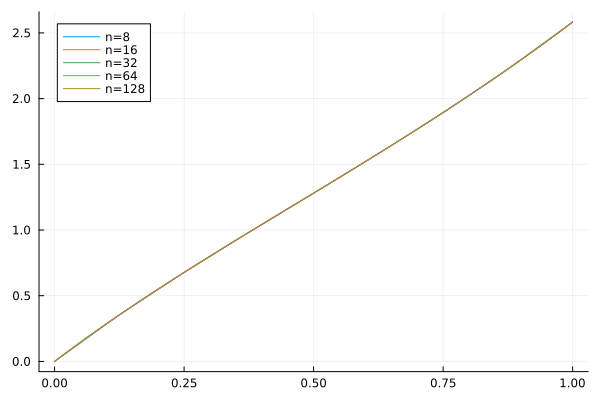

In [17]:
sol = []
for n in [8, 16, 32, 64, 128]
    stats = ipopt(cv_model(n), print_level = 0)
    solu = vcat(0, stats.solution, ℯ-ℯ^(-2))
    push!(sol, solu)
end
sol[1]

x = []
for n in [8, 16, 32, 64, 128]
    r = collect(LinRange(0, 1, n+1))
    push!(x, r)
end

using Plots
plot(x, sol, label=["n=8" "n=16" "n=32" "n=64" "n=128"])

### Question 3: Comparer à la solution exacte

La solution exacte est $x(t)=e^t - e^{-2t}$ et la valeur optimale est $e^3 - 2e^{-3}+1$.

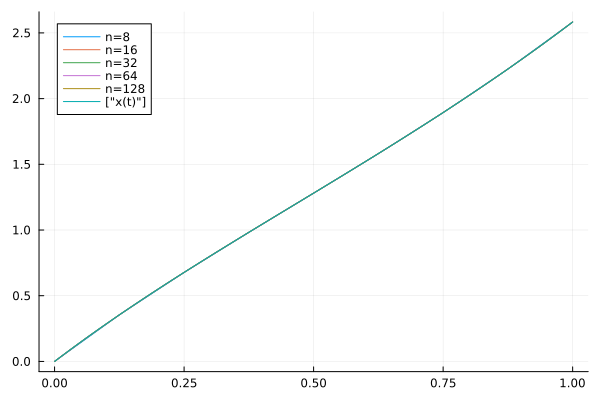

In [18]:
t = x[5]
val = ℯ*ones(length(t))
y = val.^t - val.^(-2*t)
plot!(t, y, label=["x(t)"])